# Set up

### Libraries

In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import math
import lightgbm as lgbm
import os

from dython import nominal
from sklearn                 import model_selection  as ms
from matplotlib              import pyplot as plt
from sklearn                 import ensemble         as en
from sklearn                 import neighbors        as nh
from sklearn                 import linear_model     as lm
import scikitplot as skplt


# from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, ndcg_score, classification_report
import lightgbm as lgbm
import lightgbm as lgb
from sklearn.tree import export_graphviz
# import graphviz
from IPython.display         import HTML
from skopt                   import BayesSearchCV
from sklearn.compose         import make_column_transformer, ColumnTransformer
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from tabulate                import tabulate
# from boruta                  import BorutaPy
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
# from sklearn                 import model_selection, metrics
from xgboost                 import XGBClassifier
from sklearn.metrics         import make_scorer, accuracy_score
# from sklearn.inspection      import permutation_importance
# from imblearn.pipeline       import Pipeline, make_pipeline
# from category_encoders       import TargetEncoder
# from sklearn.feature_selection import SelectFromModel, RFE
# from sklearn.base           import BaseEstimator, TransformerMixin


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



### Functions

In [155]:
# def cross_validation(model_name, model, X_train, Y_train, k, verbose=False):
#     precision_k_list = []
#     recall_k_list = []

#     # data preparation
#     X_train_cv, Y_train_cv = preprocessing_cv(X_train, Y_train)


#     kfs = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

#     for train_index, test_index in kfs.split(X_train_cv, Y_train_cv):

#         x_train_cv = X_train_cv.iloc[train_index]
#         y_train_cv = Y_train_cv.iloc[train_index]

#         x_val_cv = X_train_cv.iloc[test_index]
#         y_val_cv = Y_train_cv.iloc[test_index]

#         model.fit(x_train_cv, y_train_cv)

#         # prediction
#         yhat = model.predict_proba(x_val_cv)
#         yhat_pred = model.predict(x_val_cv)

#         # adicionando x e y num dataframe 
#         data = x_val_cv.copy()
#         data['response'] = y_val_cv.copy()

#         # coluna score no dataframe
#         data['score'] = yhat[:, 1].tolist()

#         data = data.sort_values('score', ascending = False)

#         # performance
#         precision_k = precision_at_k(data, k)
#         precision_k_list.append(precision_k)

#         recall_k = recall_at_k(data, k)
#         recall_k_list.append(recall_k)

#         acc = accuracy_score(y_val_cv, yhat_pred)

#         return pd.DataFrame({'Precision @k CV': np.round(np.mean(precision_k_list), 3),
#                          'Recall @k CV': np.round(np.mean(recall_k_list), 3),
#                          'Accuracy': np.round(np.mean(acc), 3)},index=[model_name])


def ndcg_score(y_true, y_pred, k=None):
    # y_true: lista de relevâncias binárias (1 para relevante, 0 para não relevante)
    # y_pred: lista de pontuações preditas pelo modelo
    # k: número de elementos para considerar no cálculo do NDCG (se for None, usa o tamanho total)

    if k is None:
        k = len(y_true)

    # Ordena as listas de relevâncias e predições pelo valor predito (do maior para o menor)
    sorted_indices = np.argsort(y_pred)[::-1]
    y_true_sorted = np.take(y_true, sorted_indices)[:k]

    # Calcula o DCG (Discounted Cumulative Gain)
    dcg = np.sum(y_true_sorted / np.log2(np.arange(2, k + 2)))

    # Ordena as listas de relevâncias idealmente (todas relevâncias relevantes primeiro)
    ideal_sorted_indices = np.argsort(y_true)[::-1]
    ideal_sorted = np.take(y_true, ideal_sorted_indices)[:k]

    # Calcula o IDCG (Ideal Discounted Cumulative Gain)
    idcg = np.sum(ideal_sorted / np.log2(np.arange(2, k + 2)))

    # Calcula o NDCG (Normalized Discounted Cumulative Gain)
    ndcg_scorer = dcg / idcg if idcg > 0 else 0.0

    return ndcg_scorer

def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [156]:
def preprocessing_cv(X_data, Y_data):  
    
    df_data = pd.concat([X_data, Y_data], axis=1) # juntar as variaveis preditoras com a variavel alvo

    le = LabelEncoder()
    rs = RobustScaler()
    mms = MinMaxScaler()

    df_data['carrier_delay_in_minutes'] = rs.fit_transform(df_data[['carrier_delay_in_minutes']].values)
    df_data['delivery_delay_in_minutes'] = rs.fit_transform(df_data[['delivery_delay_in_minutes']].values)
    df_data['sum_delay_in_minute'] = rs.fit_transform(df_data[['sum_delay_in_minute']].values)
    df_data['sub_delay_in_minute'] = rs.fit_transform(df_data[['sub_delay_in_minute']].values)
    df_data['delivery_delay_in_hour'] = rs.fit_transform(df_data[['delivery_delay_in_hour']].values)
    df_data['carrier_delay_in_hour'] = rs.fit_transform(df_data[['carrier_delay_in_hour']].values)
    df_data['carrier_delay_in_min'] = le.fit_transform(df_data['carrier_delay_in_min'])
    df_data['delivery_delay_in_min'] = le.fit_transform(df_data['delivery_delay_in_min'])
    df_data['gender'] = le.fit_transform(df_data['gender'])
    df_data['customer_type'] = le.fit_transform(df_data['customer_type'])
    df_data['type_of_purchase'] = le.fit_transform(df_data['type_of_purchase'])
    df_data['store_size'] = le.fit_transform(df_data['store_size'])
    df_data['carrier_delay'] = le.fit_transform(df_data['carrier_delay'])
    df_data['delivery_delay'] = le.fit_transform(df_data['delivery_delay'])
    df_data['satisfaction'] = le.fit_transform(df_data['satisfaction'])



    # Feature selection
    cols_selected = ['type_of_purchase', 'instore_wifi', 'dressing_room', 'store_size', 'customer_type', 
                 'waiting_room', 'kids_entertainment','easy_of_online_shopping', 'showroom', 'seller_service', 'cleanliness', 'self_store' ]

    X_data = df_data[cols_selected]
    Y_data = df_data['satisfaction']

    return X_data, Y_data



def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['satisfaction'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']
    
# def recall_at_k(data, k=2000):

#     # reset index
#     data = data.reset_index(drop = True)

#     # create ranking order
#     data['ranking'] = data.index + 1

#     data['recall_at_k'] = data['statisfaction'].cumsum() / data['statisfaction'].sum()

#     return data.loc[k, 'recall_at_k']

In [ ]:
# def preprocessing_cv(X_data, Y_data):  
    
#     df_data = pd.concat([X_data, Y_data], axis=1) # juntar as variaveis preditoras com a variavel alvo
    
#     df_data['vintage'] = mms_vintage.transform(df_data[['vintage']].values)
#     df_train['vintage'] = mms_vintage.fit_transform(df_train[['vintage']].values)
    
#     df_data['annual_premium'] = ss.transform(df_data[['annual_premium']].values)
    
#     df_data['age'] = mms.transform(df_data[['age']].values)
#     df_train['age'] = mms_age.fit_transform(df_train[['age']].values)
    
#     df_data['region_code'] = df_data['region_code'].astype(str)
#     df_data['region_code'] = target_encode_region.transform(df_data['region_code'])
    
#     df_data['vehicle_damage'] = df_data['vehicle_damage'].map(damage_dict)
    
#     df_data['policy_sales_channel'] = df_data['policy_sales_channel'].map(fe_policy_sales_channel)
    
#     df_data['gender'] = target_encode_gender.transform(df_data['gender'])

#     df_data = pd.get_dummies(df_data, prefix='vehicle_age', columns=['vehicle_age'])

#     df_data['age_group'] = df_data['age_group'].map(age_group_dict)
#     df_data = df_data.fillna(0)
    
#     # Feature selection
#     cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 
#                  'policy_sales_channel', 'previously_insured']
    
#     X_data = df_data[cols_selected]
#     Y_data = df_data['response']

In [3]:
jupyter_settings()

### Import Data

In [4]:
df_train_raw = pd.read_csv('train.csv', low_memory=False)

## ETL

### Data Raw status

In [5]:
df1 = df_train_raw.copy()

#### Dados

In [6]:
df1.head(5)

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,Store location,Toilet cleaning,Dressing room,Waiting room,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,Satisfied


In [7]:
df1.dtypes

id                              int64
Gender                         object
Customer Type                  object
Age                             int64
Type of Purchase               object
Store size                     object
Store distance                  int64
InStore wifi                    int64
Open/Close time convenient      int64
Easy of online shopping         int64
Store location                  int64
Toilet cleaning                 int64
Dressing room                   int64
Waiting room                    int64
Kids entertainment              int64
Seller service                  int64
Showroom                        int64
Self-Store                      int64
Purchase service                int64
Store Service                   int64
Cleanliness                     int64
Carrier delay in minutes        int64
Delivery delay in minutes     float64
Satisfaction                   object
dtype: object

In [8]:
df1.isna().sum()

id                              0
Gender                          0
Customer Type                   0
Age                             0
Type of Purchase                0
Store size                      0
Store distance                  0
InStore wifi                    0
Open/Close time convenient      0
Easy of online shopping         0
Store location                  0
Toilet cleaning                 0
Dressing room                   0
Waiting room                    0
Kids entertainment              0
Seller service                  0
Showroom                        0
Self-Store                      0
Purchase service                0
Store Service                   0
Cleanliness                     0
Carrier delay in minutes        0
Delivery delay in minutes     310
Satisfaction                    0
dtype: int64

### Rename Columns

In [9]:
df1.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase',
       'Store size', 'Store distance', 'InStore wifi',
       'Open/Close time convenient', 'Easy of online shopping',
       'Store location', 'Toilet cleaning', 'Dressing room', 'Waiting room',
       'Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store',
       'Purchase service', 'Store Service', 'Cleanliness',
       'Carrier delay in minutes', 'Delivery delay in minutes',
       'Satisfaction'],
      dtype='object')

In [10]:
old_columns = [ 'id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase',
       'Store size', 'Store distance', 'InStore wifi',
       'Open/Close time convenient', 'Easy of online shopping',
       'Store location', 'Toilet cleaning', 'Dressing room', 'Waiting room',
       'Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store',
       'Purchase service', 'Store Service', 'Cleanliness',
       'Carrier delay in minutes', 'Delivery delay in minutes',
       'Satisfaction' ]


old_columns = pd.Series(old_columns).apply(lambda x: x.strip().replace(' ', '_').lower())

# Rename
df1.columns = old_columns
df1 = df1.rename(columns={'self-store':'self_store'})

df1.columns

Index(['id', 'gender', 'customer_type', 'age', 'type_of_purchase',
       'store_size', 'store_distance', 'instore_wifi',
       'open/close_time_convenient', 'easy_of_online_shopping',
       'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
       'kids_entertainment', 'seller_service', 'showroom', 'self_store',
       'purchase_service', 'store_service', 'cleanliness',
       'carrier_delay_in_minutes', 'delivery_delay_in_minutes',
       'satisfaction'],
      dtype='object')

In [11]:
# Ordinal Encoder - instore_wifi, open/close_time_convenient, easy_of_online_shopping, store_location, toilet_cleaning, 
                    # dressing_room, waiting_room, kids_entertainment, seller_service, showroom, self_store, purchase_service, store_service, cleanliness


# Descriptive Statistical

### Data Dimensions

In [12]:
print(f'Number of Rows {df1.shape[0]}')
print(f'Number of Columns {df1.shape[1]}')

Number of Rows 103904
Number of Columns 24


### Basics Statistics

In [13]:
df2 = df1.copy()

In [14]:
# Split Numerical/Categorical Atributes

num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes( include=['object'])

In [15]:
# Cental Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( np.min )).T
d3 = pd.DataFrame(num_attributes.apply( np.max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T


# Concatenate
table_m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
table_m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

table_m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,129880.0,129879.0,64924.210502,64856.5,37463.631970,0.002864,-1.198440
1,age,7.0,85.0,78.0,39.379706,40.0,15.114891,-0.004516,-0.719568
2,store_distance,31.0,4983.0,4952.0,1189.448375,843.0,997.142482,1.109466,0.268535
3,instore_wifi,0.0,5.0,5.0,2.729683,3.0,1.327823,0.040408,-0.846170
4,open/close_time_convenient,0.0,5.0,5.0,3.060296,3.0,1.525068,-0.334399,-1.037767
5,easy_of_online_shopping,0.0,5.0,5.0,2.756901,3.0,1.398923,-0.018294,-0.910346
6,store_location,0.0,5.0,5.0,2.976883,3.0,1.277615,-0.058889,-1.030283
7,toilet_cleaning,0.0,5.0,5.0,3.202129,3.0,1.329526,-0.151279,-1.145453
8,dressing_room,0.0,5.0,5.0,3.250375,3.0,1.349502,-0.453852,-0.702006
9,waiting_room,0.0,5.0,5.0,3.439396,4.0,1.319081,-0.482775,-0.925702


In [16]:
# Outra maneira de fazer a descrição: 
df2.select_dtypes(include=['int64','float64']).describe().T


,count,mean,std,min,25%,50%,75%,max
id,103904.0,64924.210502,37463.812252,1.0,32533.75,64856.5,97368.25,129880.0
age,103904.0,39.379706,15.114964,7.0,27.00,40.0,51.00,85.0
store_distance,103904.0,1189.448375,997.147281,31.0,414.00,843.0,1743.00,4983.0
instore_wifi,103904.0,2.729683,1.327829,0.0,2.00,3.0,4.00,5.0
open/close_time_convenient,103904.0,3.060296,1.525075,0.0,2.00,3.0,4.00,5.0
easy_of_online_shopping,103904.0,2.756901,1.398929,0.0,2.00,3.0,4.00,5.0
store_location,103904.0,2.976883,1.277621,0.0,2.00,3.0,4.00,5.0
toilet_cleaning,103904.0,3.202129,1.329533,0.0,2.00,3.0,4.00,5.0
dressing_room,103904.0,3.250375,1.349509,0.0,2.00,3.0,4.00,5.0
waiting_room,103904.0,3.439396,1.319088,0.0,2.00,4.0,5.00,5.0


### Cat/Num analysis

In [17]:
# Quantos linhas > 0 temos em 'delivery_delay_in_minutes'

df2[df2['delivery_delay_in_minutes'] > 0].select_dtypes(include=['int64','float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
id,45435.0,65318.131286,37976.528318,1.0,32028.0,65225.0,99790.0,129879.0
age,45435.0,39.201497,15.122848,7.0,27.0,39.0,51.0,85.0
store_distance,45435.0,1180.945571,990.756806,31.0,420.0,837.0,1721.0,4983.0
instore_wifi,45435.0,2.680158,1.289738,0.0,2.0,3.0,4.0,5.0
open/close_time_convenient,45435.0,3.055002,1.512327,0.0,2.0,3.0,4.0,5.0
easy_of_online_shopping,45435.0,2.738990,1.380472,0.0,2.0,3.0,4.0,5.0
store_location,45435.0,2.983405,1.273867,1.0,2.0,3.0,4.0,5.0
toilet_cleaning,45435.0,3.160735,1.333214,0.0,2.0,3.0,4.0,5.0
dressing_room,45435.0,3.190074,1.339813,0.0,2.0,3.0,4.0,5.0
waiting_room,45435.0,3.395268,1.322034,0.0,2.0,4.0,4.0,5.0


In [18]:
cat_attributes = df1.select_dtypes( include=['object']).sample(10)
cat_attributes

,gender,customer_type,type_of_purchase,store_size,satisfaction
47662,Female,Loyal Customer,Personal,Small,Neutral or Dissatisfaction
28019,Male,Loyal Customer,Gift,Large,Satisfied
59093,Male,Loyal Customer,Gift,Medium,Neutral or Dissatisfaction
77265,Male,Loyal Customer,Gift,Large,Satisfied
74530,Female,Loyal Customer,Personal,Medium,Neutral or Dissatisfaction
87709,Male,Loyal Customer,Personal,Medium,Neutral or Dissatisfaction
2074,Female,Loyal Customer,Personal,Medium,Neutral or Dissatisfaction
14647,Male,Loyal Customer,Gift,Large,Neutral or Dissatisfaction
28780,Male,Loyal Customer,Gift,Large,Satisfied
83950,Male,Loyal Customer,Gift,Medium,Neutral or Dissatisfaction


In [19]:
df2 = df2[df2['age'] >= 15]

# Verificando numero de linhas sem NAN
df2 = df2[~df2['delivery_delay_in_minutes'].isna()]

In [20]:
# Volume de pessoas 'Satisfied'
len(df2[df2['satisfaction'] == 'Satisfied'])

44176

### Univariate Analysis

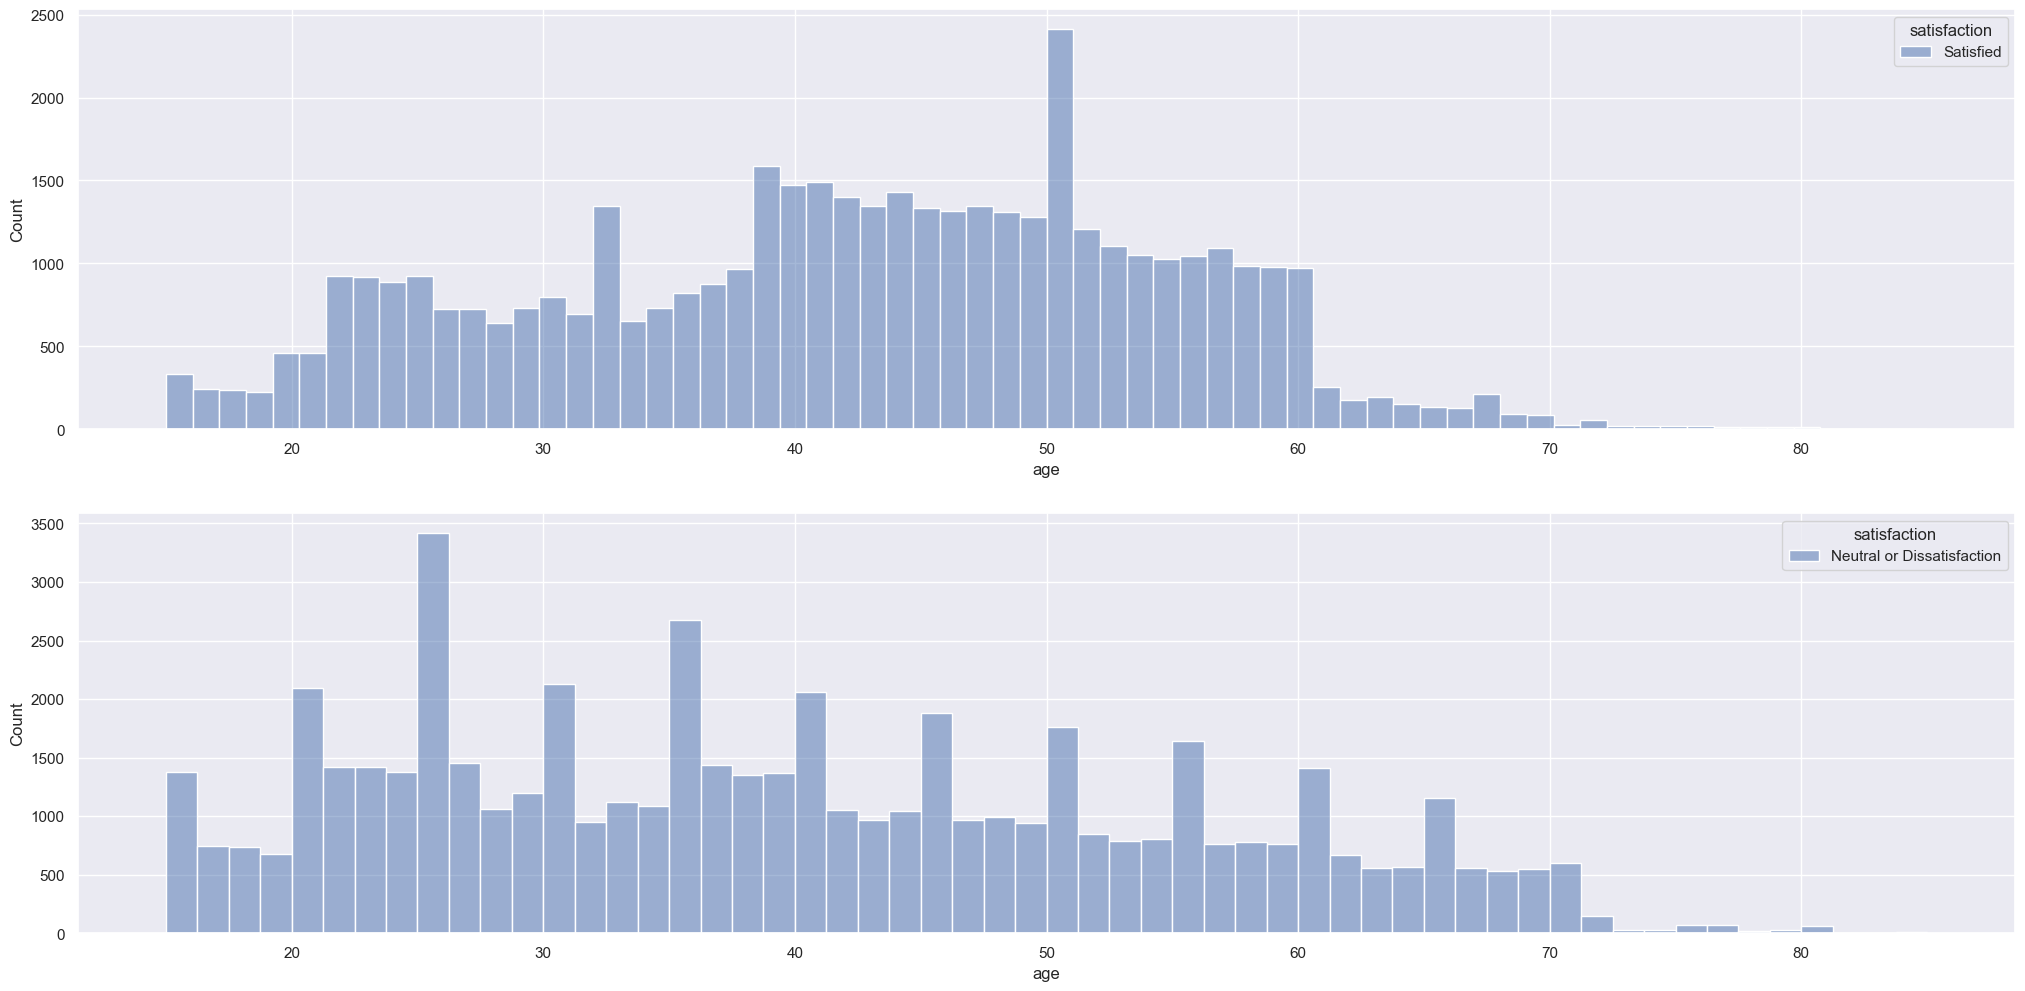

In [21]:
#Age analysis
plt.subplot(2,1,1)
sns.histplot(x='age',
             data=df2[df2['satisfaction'] == 'Satisfied'],
             hue='satisfaction');

plt.subplot(2,1,2)
sns.histplot(x='age',
             data=df2[df2['satisfaction'] == 'Neutral or Dissatisfaction'],
             hue='satisfaction');

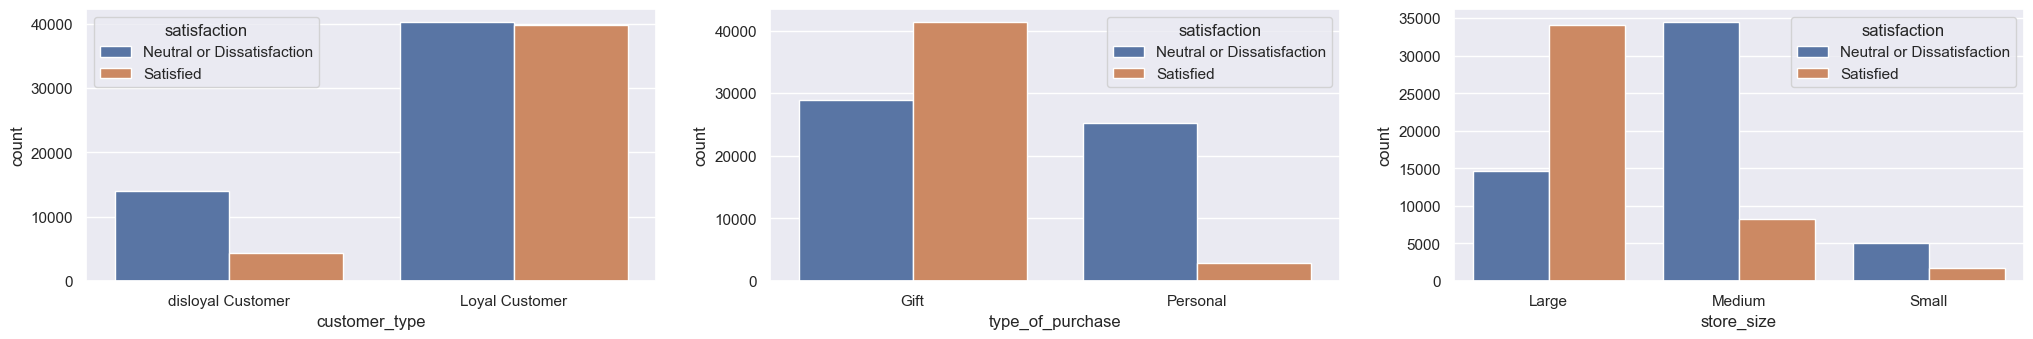

In [22]:
# Categorical analysis

plt.subplot(3,3,1)
sns.countplot(
    x='customer_type',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,2)
sns.countplot(
    x='type_of_purchase',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,3)
sns.countplot(
     x='store_size',
    hue=('satisfaction'),
    data=df2,
);



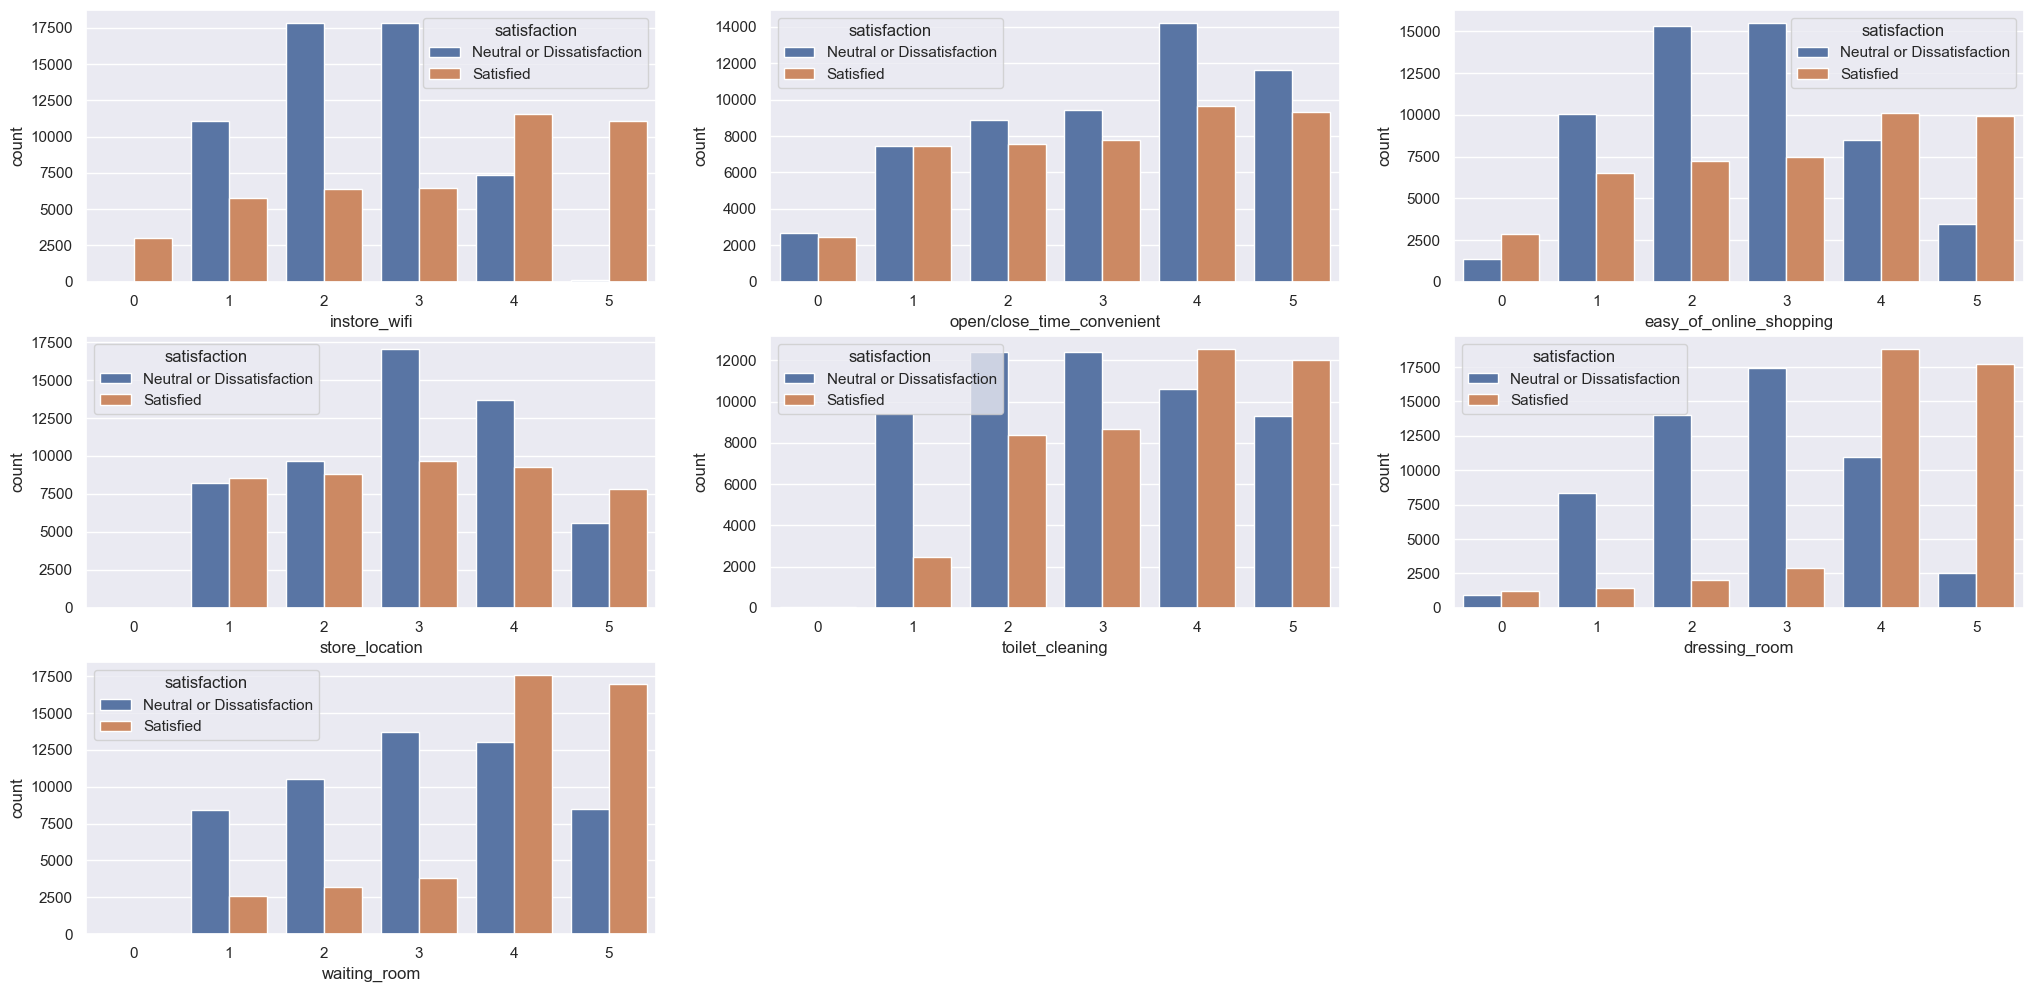

In [23]:
# Ranked analysis

plt.subplot(3,3,1)
sns.countplot(
    x='instore_wifi',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,2)
sns.countplot(
    x='open/close_time_convenient',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,3)
sns.countplot(
     x='easy_of_online_shopping',
    hue=('satisfaction'),
    data=df2,
);



plt.subplot(3,3,4)
sns.countplot(
     x='store_location',
    hue=('satisfaction'),
    data=df2,
);



plt.subplot(3,3,5)
sns.countplot(
     x='toilet_cleaning',
    hue=('satisfaction'),
    data=df2,
);


plt.subplot(3,3,6)
sns.countplot(
     x='dressing_room',
    hue=('satisfaction'),
    data=df2,
);


plt.subplot(3,3,7)
sns.countplot(
     x='waiting_room',
    hue=('satisfaction'),
    data=df2,
);



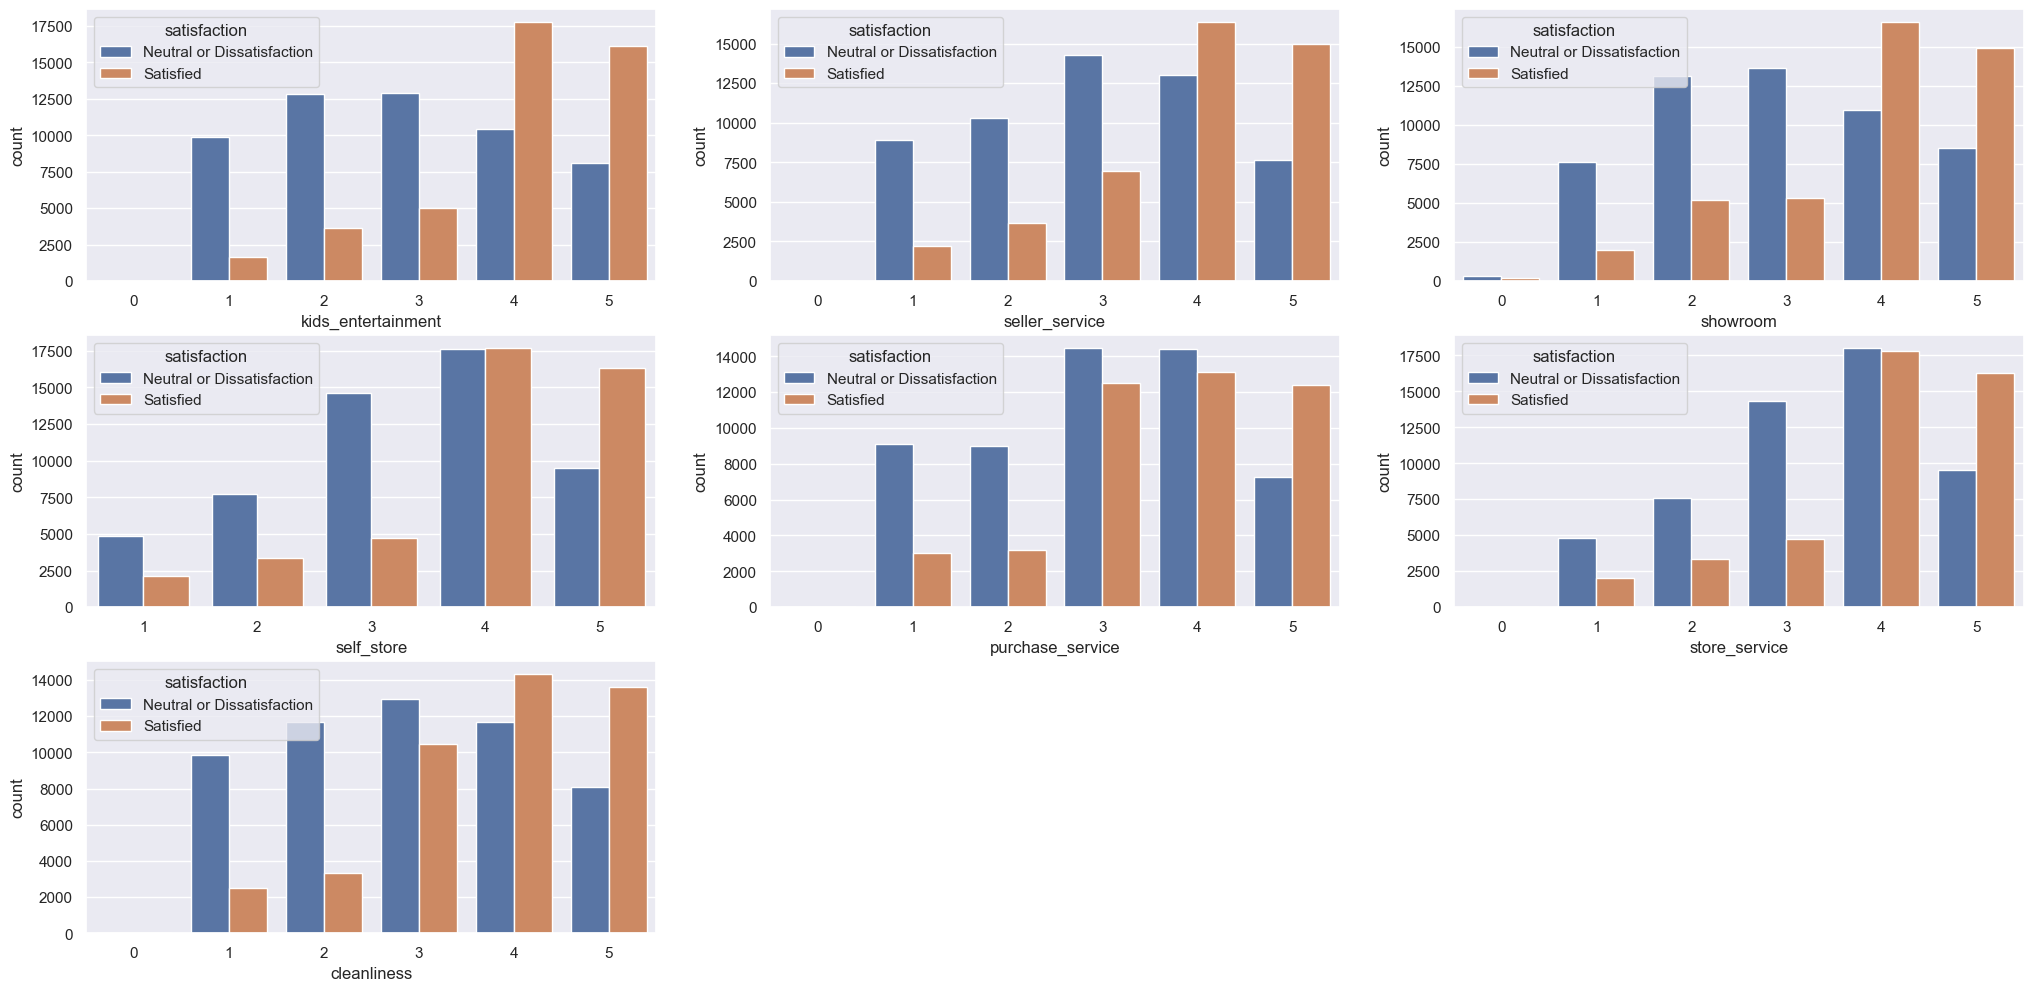

In [24]:
# Ranked analysis

plt.subplot(3,3,1)
sns.countplot(
     x='kids_entertainment',
    hue=('satisfaction'),
    data=df2,
);


plt.subplot(3,3,2)
sns.countplot(
     x='seller_service',
    hue=('satisfaction'),
    data=df2,
);


plt.subplot(3,3,3)
sns.countplot(
     x='showroom',
    hue=('satisfaction'),
    data=df2,
);



plt.subplot(3,3,4)
sns.countplot(
     x='self_store',
    hue=('satisfaction'),
    data=df2,
);


plt.subplot(3,3,5)
sns.countplot(
     x='purchase_service',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,6)
sns.countplot(
     x='store_service',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,7)
sns.countplot(
     x='cleanliness',
    hue=('satisfaction'),
    data=df2,
);

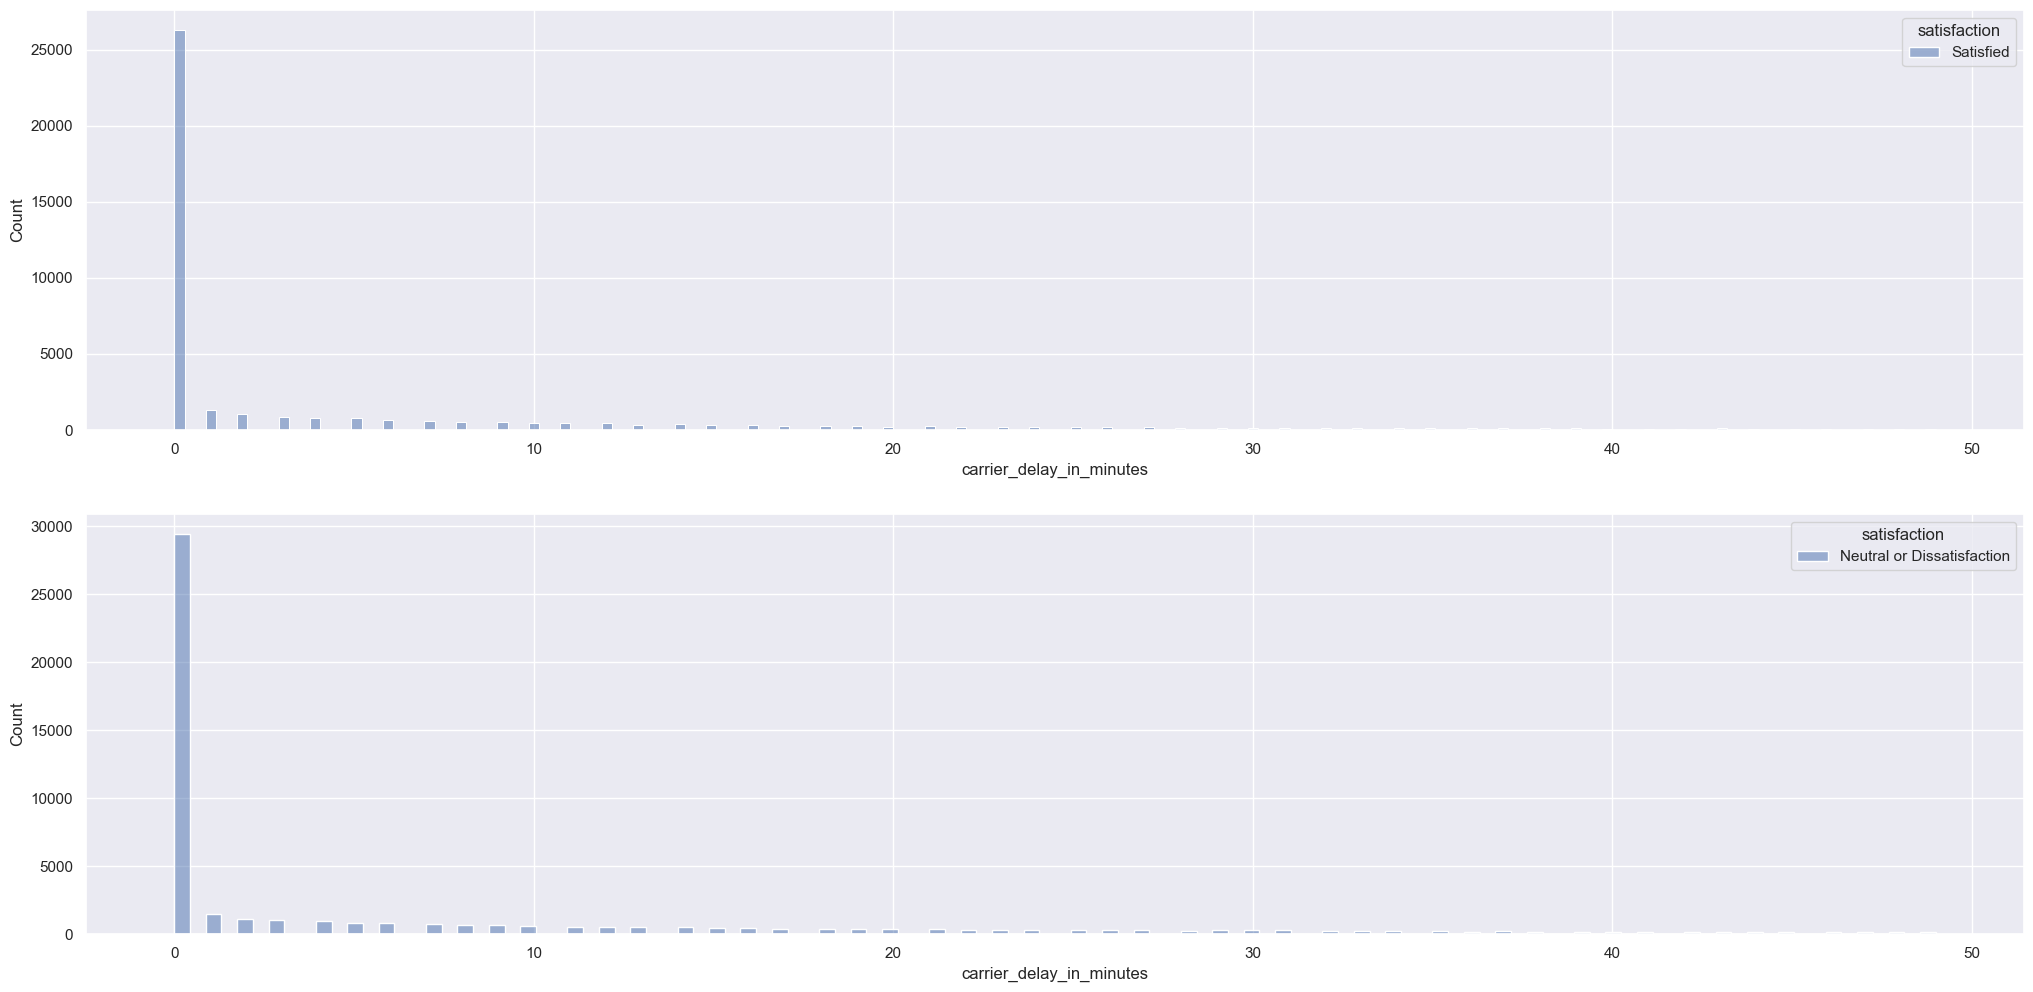

In [25]:
# 'carrier_delay_in_minutes' com tempo menor que 50 min
plt.subplot(2,1,1)
sns.histplot(x='carrier_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Satisfied') & (df2['carrier_delay_in_minutes'] < 50)],
             hue='satisfaction');

plt.subplot(2,1,2)
sns.histplot(x='carrier_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Neutral or Dissatisfaction') & (df2['carrier_delay_in_minutes'] < 50)],
             hue='satisfaction');

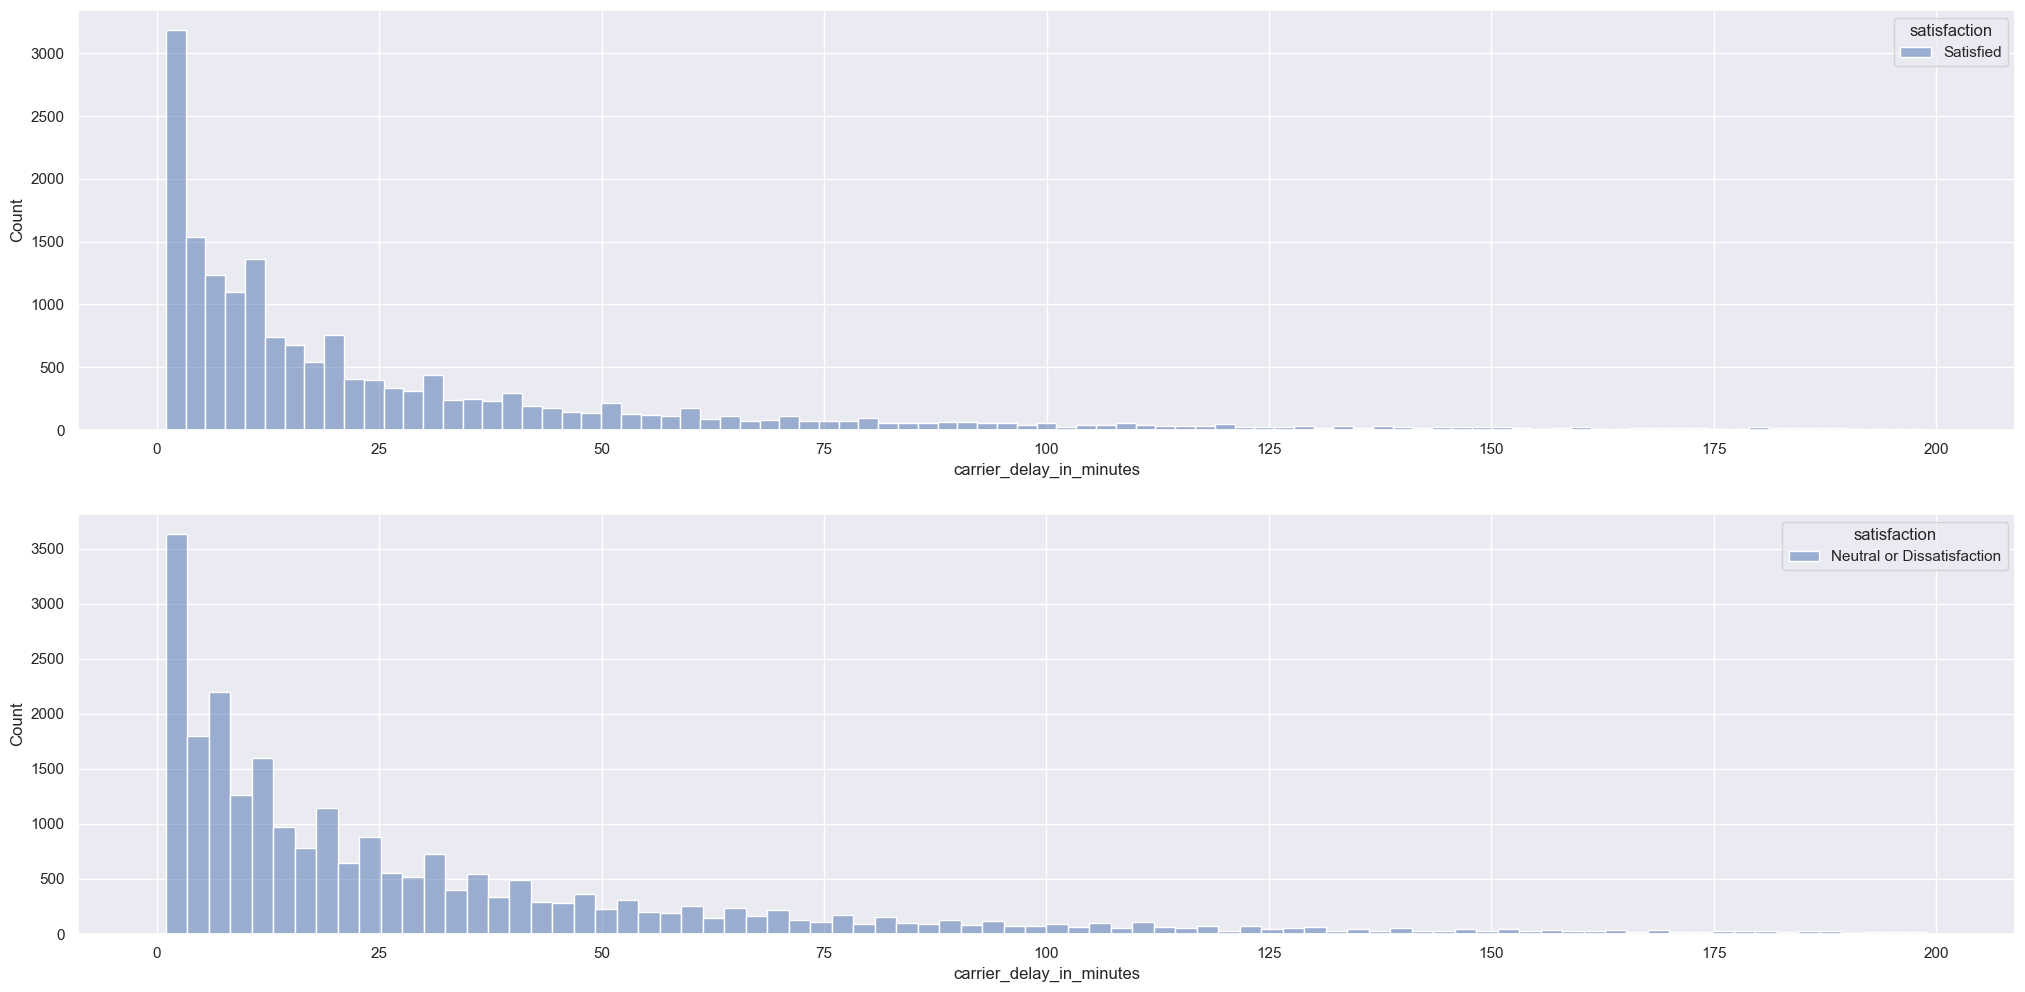

In [26]:
# 'carrier_delay_in_minutes' com tempo maior que 0 e menor que 200 min 

plt.subplot(2,1,1)
sns.histplot(x='carrier_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Satisfied') & (df2['carrier_delay_in_minutes'] > 0) & (df2['carrier_delay_in_minutes'] < 200)],
             hue='satisfaction');

plt.subplot(2,1,2)
sns.histplot(x='carrier_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Neutral or Dissatisfaction') & (df2['carrier_delay_in_minutes'] > 0) & (df2['carrier_delay_in_minutes'] < 200)],
             hue='satisfaction');

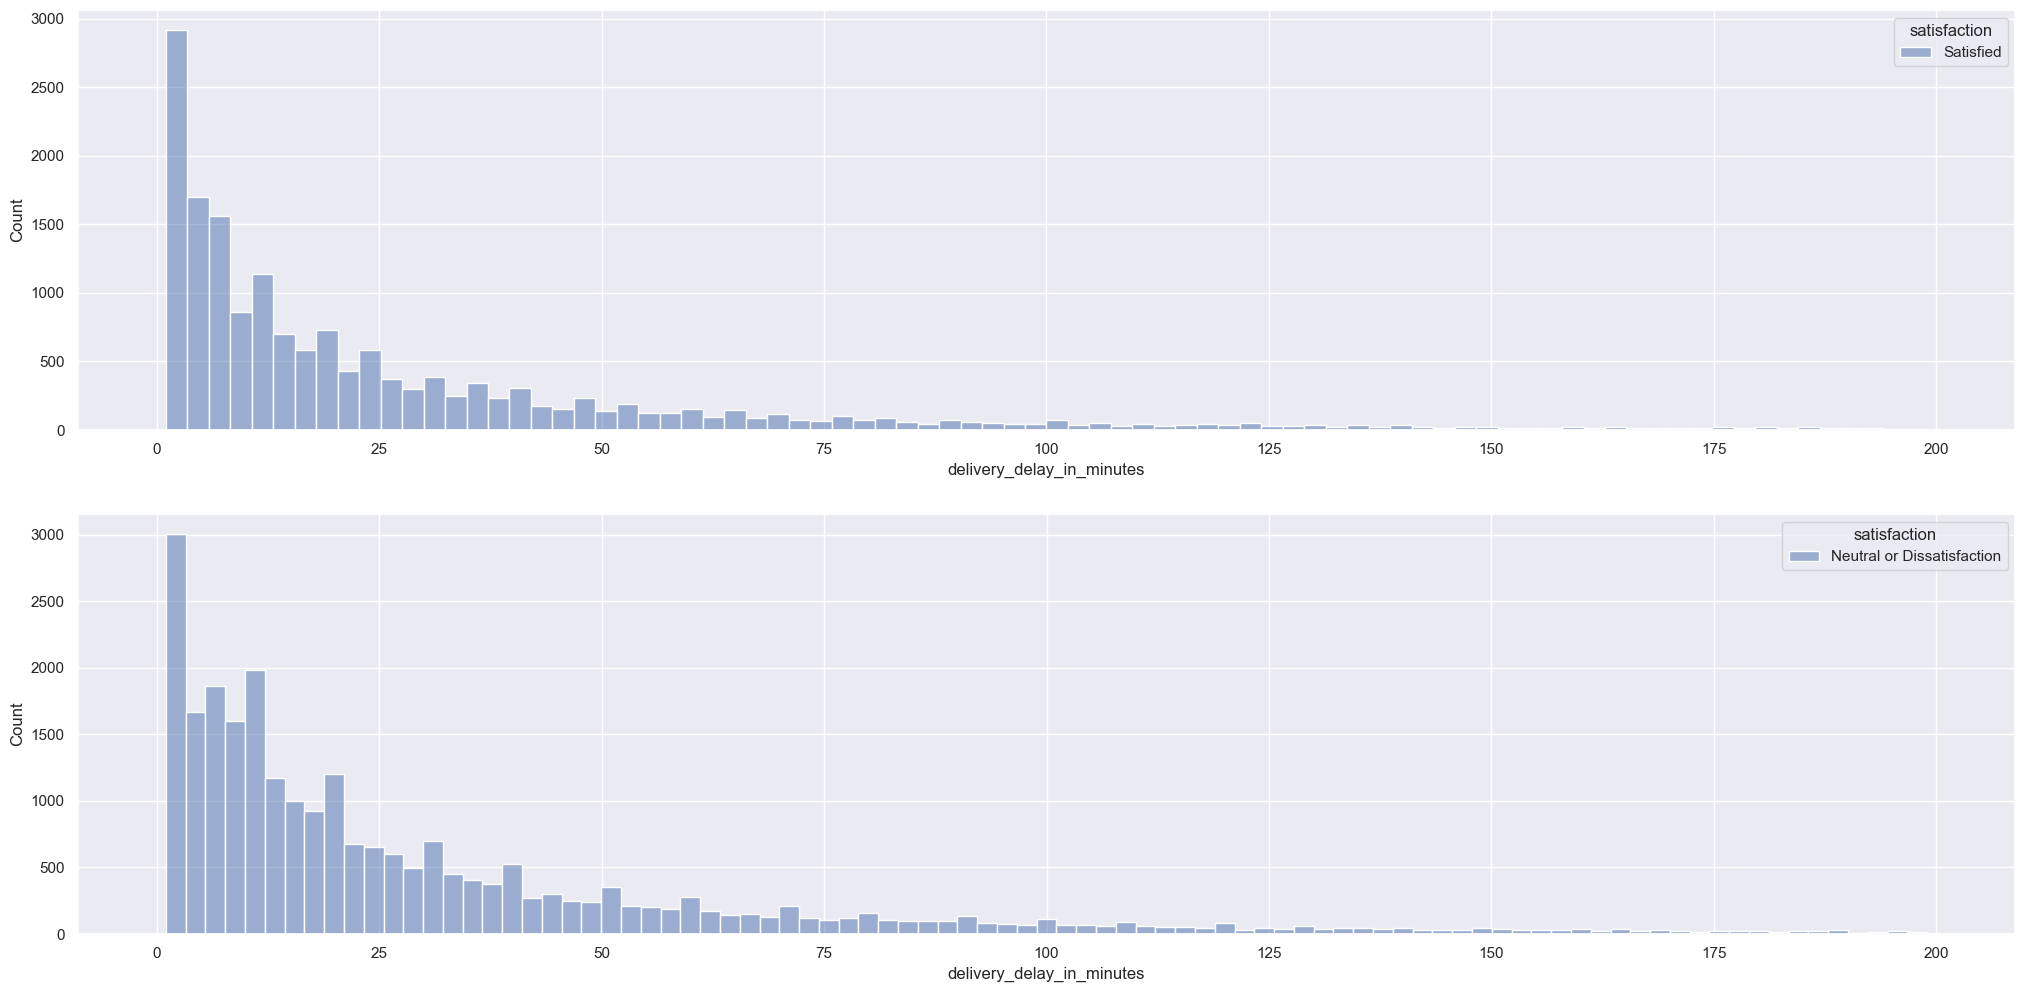

In [27]:
# 'delivery_delay_in_minutes' com tempo maior que 0 e menor que 200 min 
plt.subplot(2,1,1)
sns.histplot(x='delivery_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Satisfied') & (df2['delivery_delay_in_minutes'] > 0) & (df2['delivery_delay_in_minutes'] < 200)],
             hue='satisfaction');

plt.subplot(2,1,2)
sns.histplot(x='delivery_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Neutral or Dissatisfaction') & (df2['delivery_delay_in_minutes'] > 0) & (df2['delivery_delay_in_minutes'] < 200)],
             hue='satisfaction');

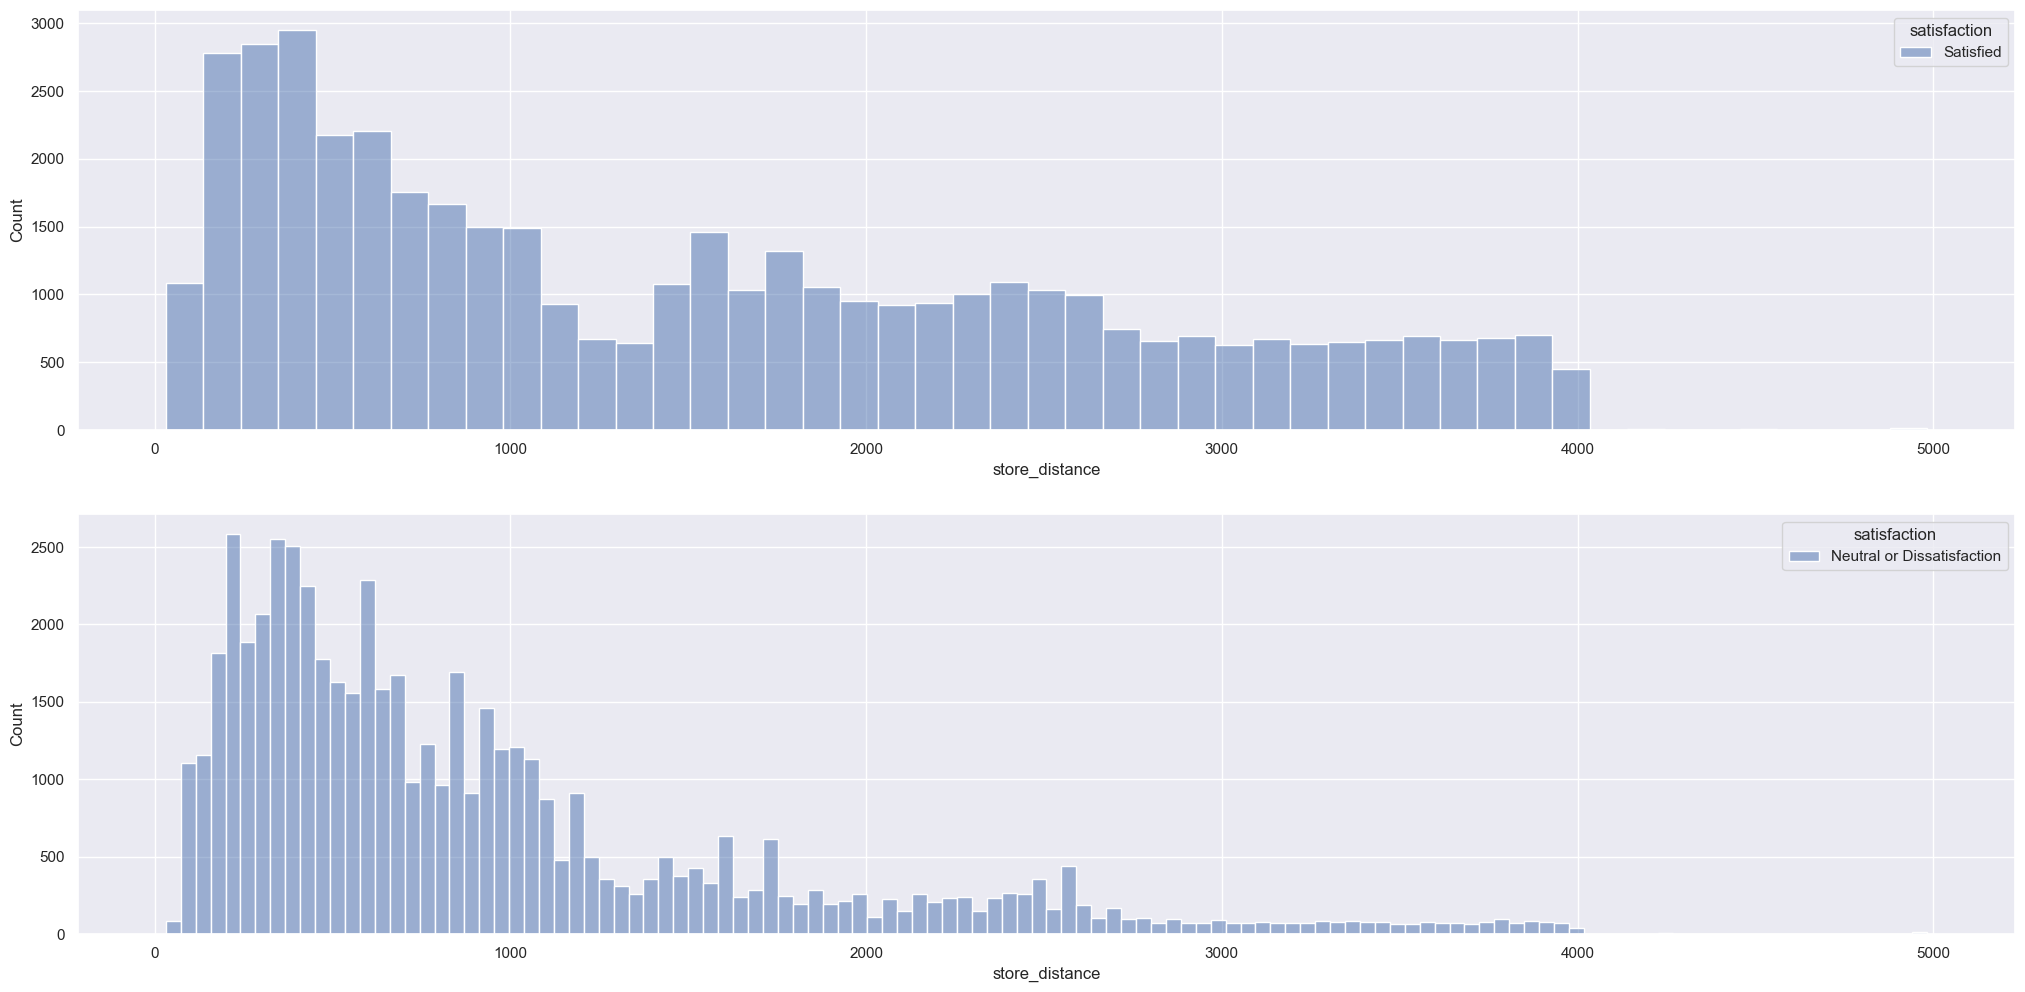

In [28]:
# Satisfação em relação à distância da loja 

plt.subplot(2,1,1)
sns.histplot(x='store_distance',
             data=df2[(df2['satisfaction'] == 'Satisfied')],
             hue='satisfaction');

plt.subplot(2,1,2)
sns.histplot(x='store_distance',
             data=df2[(df2['satisfaction'] == 'Neutral or Dissatisfaction')],
             hue='satisfaction');

### New Features

In [29]:
df3=df2.copy()

In [30]:
# carrier_delay (no = 0 yes > 1)
df3['carrier_delay'] = df3[['carrier_delay_in_minutes']].apply(lambda x: 'no' if x['carrier_delay_in_minutes'] == 0 else 'yes', axis=1)

# delivery_delay (no = 0 yes > 1)
df3['delivery_delay'] = df3[['delivery_delay_in_minutes']].apply(lambda x: 'no' if x['delivery_delay_in_minutes'] == 0 else 'yes', axis=1)

# carrier_delay_ (0 < x < 10 10 < x < 20 20 < x < 30 30 < x < 60 60 > x)
def transform_delay(x):
    if x == 0:
        return '0'
    elif x <= 10:
        return '<10'
    elif x <= 20:
        return '<20'
    elif x <= 30:
        return '<30'
    elif x <= 60:
        return '<60'
    else:
        return '>60'

df3['carrier_delay_in_min'] = df3['carrier_delay_in_minutes'].apply(transform_delay)

df3['delivery_delay_in_min'] = df3['delivery_delay_in_minutes'].apply(transform_delay)


# Soma dos atrasos
df3['delivery_delay_in_minutes'] = df3['delivery_delay_in_minutes'].astype(int)
df3['sum_delay_in_minute'] = df3['delivery_delay_in_minutes'] + df3['carrier_delay_in_minutes']


# Subtração dos atrasos.
df3['sub_delay_in_minute'] = df3['delivery_delay_in_minutes'] - df3['carrier_delay_in_minutes']
df3['sub_delay_in_minute'] = np.where(df3['sub_delay_in_minute'] <= 0, 0, df3['sub_delay_in_minute'])


# carrier_delay_in_hour
df3['carrier_delay_in_hour'] = df3['carrier_delay_in_minutes'].apply(lambda x: x/60)

#delivery_delay_in_hour
df3['delivery_delay_in_hour'] = df3['delivery_delay_in_minutes'].apply(lambda x: x/60)

In [31]:
df3.head(5)

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction,carrier_delay,delivery_delay,carrier_delay_in_min,delivery_delay_in_min,sum_delay_in_minute,sub_delay_in_minute,carrier_delay_in_hour,delivery_delay_in_hour
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,Neutral or Dissatisfaction,yes,yes,<10,<10,7,5,0.016667,0.10
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,Satisfied,no,no,0,0,0,0,0.000000,0.00
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,Neutral or Dissatisfaction,yes,yes,<20,<10,20,0,0.183333,0.15
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0,Satisfied,no,no,0,0,0,0,0.000000,0.00
5,111157,Female,Loyal Customer,26,Personal,Medium,1180,3,4,2,1,1,2,1,1,3,4,4,4,4,1,0,0,Neutral or Dissatisfaction,no,no,0,0,0,0,0.000000,0.00


In [32]:
# df3['delivery_delay_in_minutes'] = df3['delivery_delay_in_minutes'].astype(int)
df3['sub_delay_in_minute'] = df3['delivery_delay_in_minutes'] - df3['carrier_delay_in_minutes']
df3['sub_delay_in_minute'] = np.where(df3['sub_delay_in_minute'] <= 0, 0, df3['sub_delay_in_minute'])


In [33]:
df2[df2['store_distance'] < 100].head()

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction
258,44736,Female,Loyal Customer,72,Gift,Small,67,2,5,3,5,2,3,4,3,3,2,3,4,3,3,28,18.0,Neutral or Dissatisfaction
273,1150,Female,Loyal Customer,15,Personal,Medium,89,3,5,3,4,5,3,1,5,5,5,4,3,5,5,0,0.0,Neutral or Dissatisfaction
357,46695,Female,Loyal Customer,44,Personal,Medium,73,2,3,2,3,4,3,4,1,1,2,1,2,1,1,0,32.0,Neutral or Dissatisfaction
494,120723,Female,Loyal Customer,49,Gift,Large,90,4,4,2,4,3,4,4,4,4,4,4,4,4,3,0,0.0,Satisfied
600,44731,Male,Loyal Customer,40,Gift,Small,67,4,4,5,5,4,4,4,4,2,1,1,4,4,4,0,4.0,Satisfied


In [34]:
df3.head(3)

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction,carrier_delay,delivery_delay,carrier_delay_in_min,delivery_delay_in_min,sum_delay_in_minute,sub_delay_in_minute,carrier_delay_in_hour,delivery_delay_in_hour
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,Neutral or Dissatisfaction,yes,yes,<10,<10,7,5,0.016667,0.10
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,Satisfied,no,no,0,0,0,0,0.000000,0.00
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,Neutral or Dissatisfaction,yes,yes,<20,<10,20,0,0.183333,0.15


### New Features Evaluation

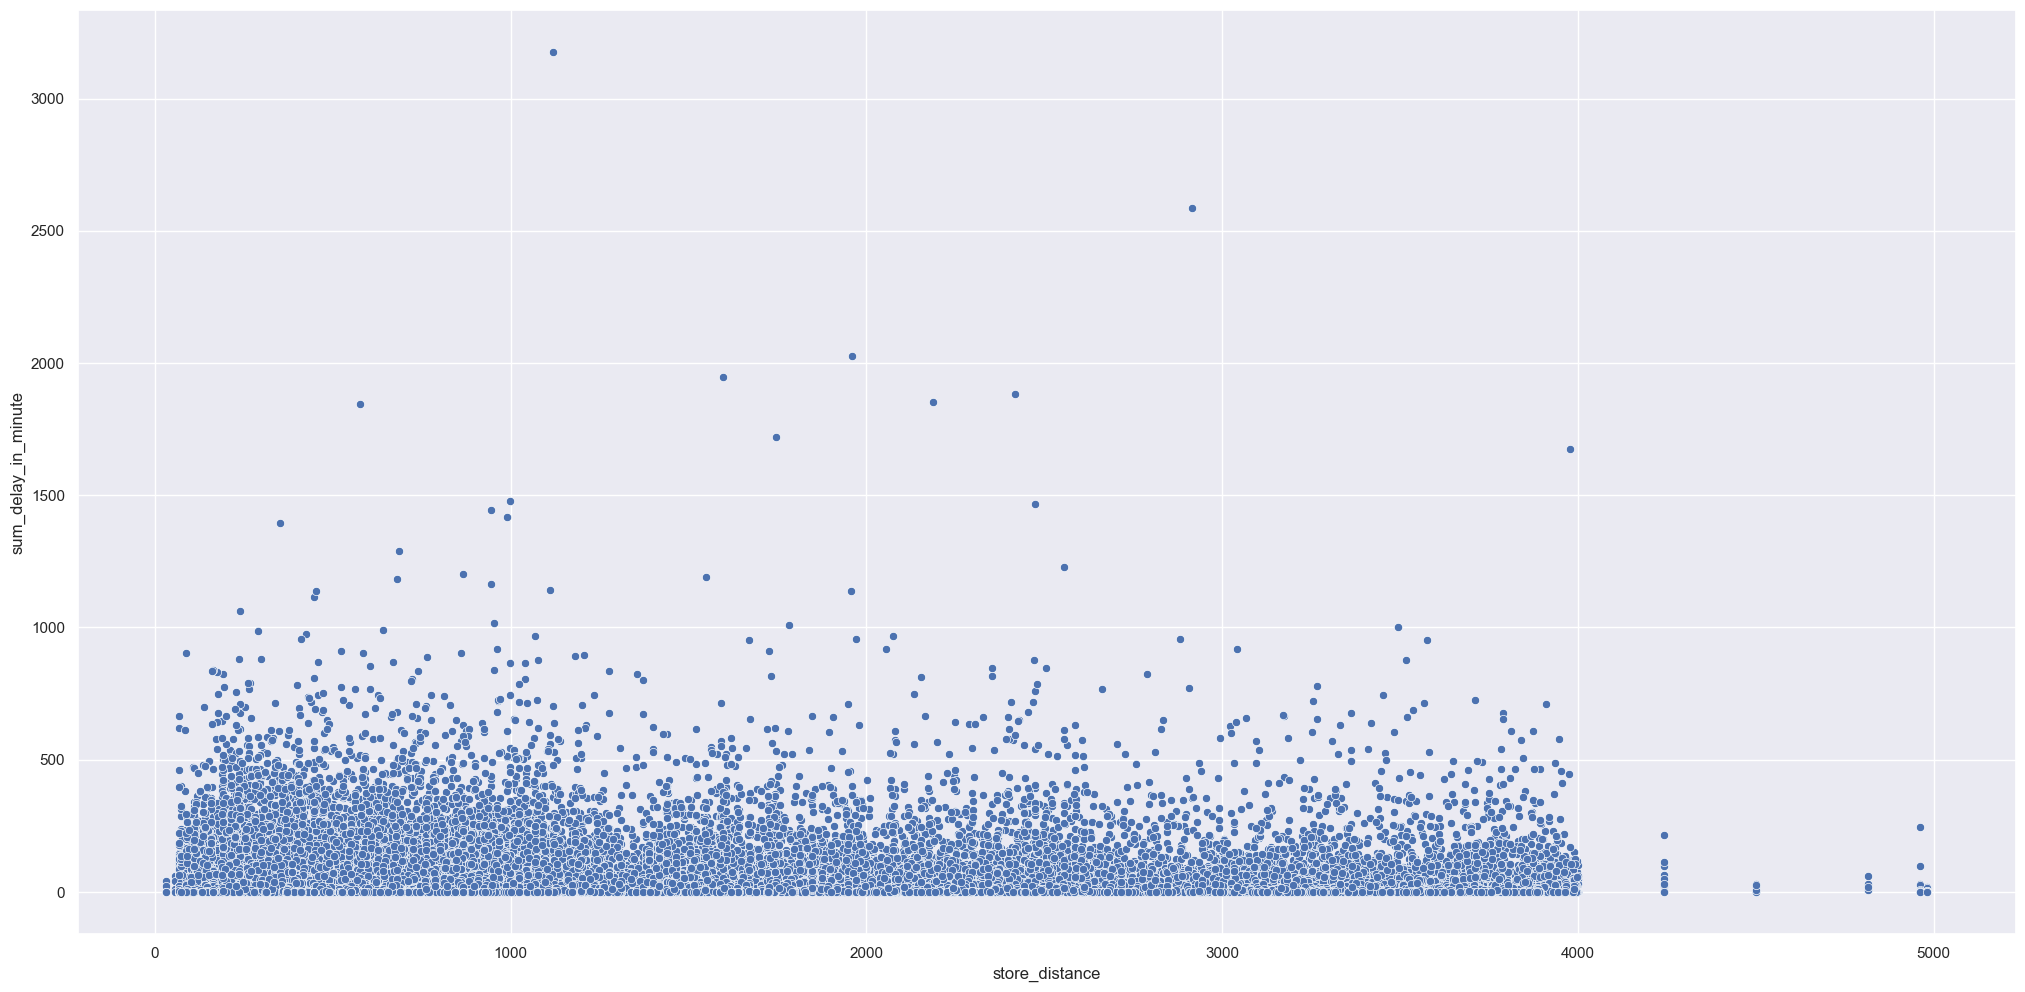

In [35]:
sns.scatterplot( x='store_distance', y='sum_delay_in_minute', data=df3);

In [36]:
df3.head(3)

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction,carrier_delay,delivery_delay,carrier_delay_in_min,delivery_delay_in_min,sum_delay_in_minute,sub_delay_in_minute,carrier_delay_in_hour,delivery_delay_in_hour
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,Neutral or Dissatisfaction,yes,yes,<10,<10,7,5,0.016667,0.10
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,Satisfied,no,no,0,0,0,0,0.000000,0.00
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,Neutral or Dissatisfaction,yes,yes,<20,<10,20,0,0.183333,0.15


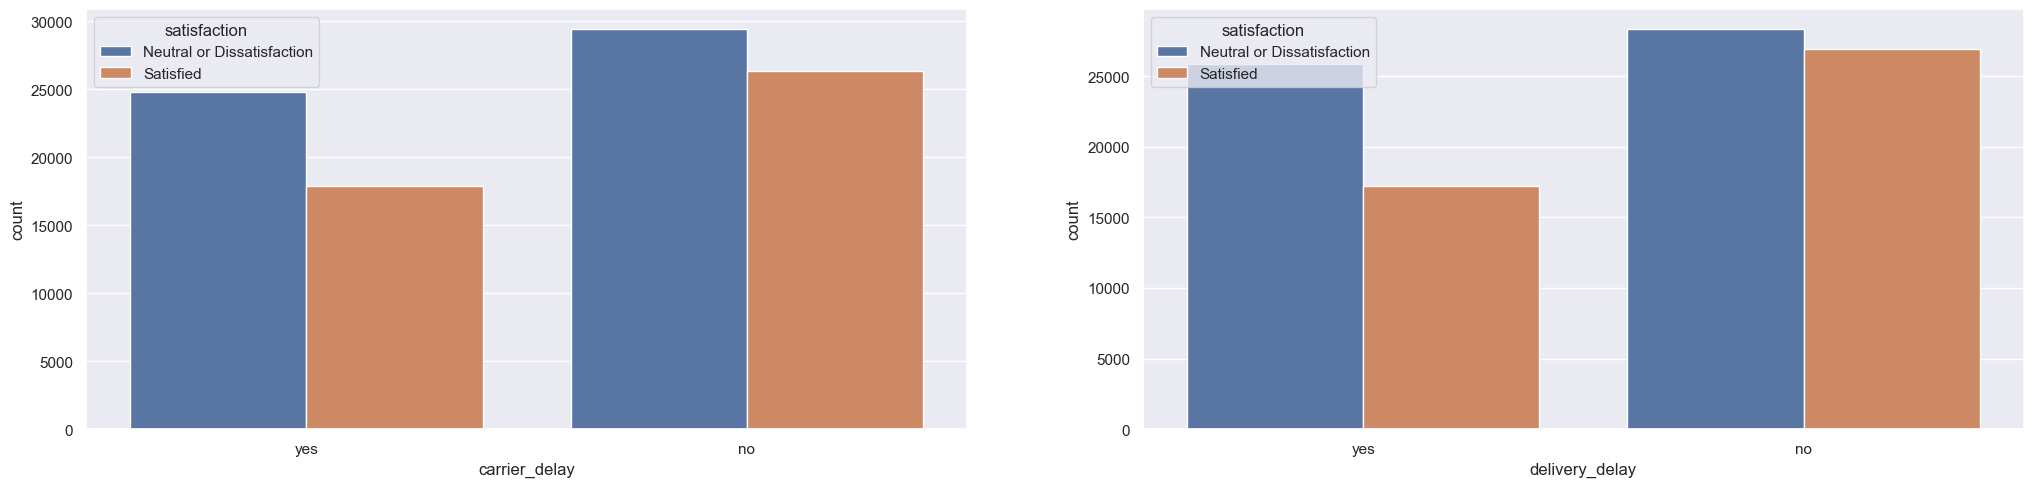

In [37]:
# Categorical analysis

plt.subplot(2,2,1)
sns.countplot(
    x='carrier_delay',
    hue=('satisfaction'),
    data=df3,
);

plt.subplot(2,2,2)
sns.countplot(
    x='delivery_delay',
    hue=('satisfaction'),
    data=df3,
);

In [38]:
# nominal.associations(df3.drop('id',axis = 1));

# Data Preparation

In [39]:
df4 = df3.copy()

### Split

In [106]:
X = df4.drop(['id','satisfaction'], axis=1)
y = df4['satisfaction']

In [107]:
# Dataset (100%) -> Treino(80%) e Teste(20%)
X_train, x_test, Y_train, y_test = ms.train_test_split(X, y, test_size=0.20)

In [108]:
# Treino(80%) -> treino(60%) e validação(20%)
x_train, x_validation, y_train, y_validation = ms.train_test_split(X_train, Y_train, test_size=0.20) 
df_train = pd.concat([x_train, y_train], axis=1) # juntar as variaveis preditoras com a variavel alvo

### Tranformations

In [109]:
# MinMaxscaler - age, carrier_delay_in_minutes, delivery_delay_in_minutes,   sum_delay_in_minute ,sub_delay_in_minute, delivery_delay_in_hour, carrier_delay_in_hour

mms = MinMaxScaler()

df_train['age'] = mms.fit_transform(df_train[['age']].values)

In [110]:
# RobustScaler - age, carrier_delay_in_minutes delivery_delay_in_minutes,    sum_delay_in_minute sub_delay_in_minute delivery_delay_in_hour carrier_delay_in_hour

rs = RobustScaler()

df_train['carrier_delay_in_minutes'] = rs.fit_transform(df_train[['carrier_delay_in_minutes']].values)
df_train['delivery_delay_in_minutes'] = rs.fit_transform(df_train[['delivery_delay_in_minutes']].values)
df_train['sum_delay_in_minute'] = rs.fit_transform(df_train[['sum_delay_in_minute']].values)
df_train['sub_delay_in_minute'] = rs.fit_transform(df_train[['sub_delay_in_minute']].values)
df_train['delivery_delay_in_hour'] = rs.fit_transform(df_train[['delivery_delay_in_hour']].values)
df_train['carrier_delay_in_hour'] = rs.fit_transform(df_train[['carrier_delay_in_hour']].values)



In [111]:
# Label encoder - gender, customer_type, type_of_purchase, store_size, carrier_delay, delivery_delay, carrier_delay_in_min, delivery_delay_in_min

# Crie uma instância do LabelEncoder
le = LabelEncoder()


# Ajuste e transforme a coluna 'gender' do DataFrame
df_train['carrier_delay_in_min'] = le.fit_transform(df_train['carrier_delay_in_min'])
df_train['delivery_delay_in_min'] = le.fit_transform(df_train['delivery_delay_in_min'])
df_train['gender'] = le.fit_transform(df_train['gender'])
df_train['customer_type'] = le.fit_transform(df_train['customer_type'])
df_train['type_of_purchase'] = le.fit_transform(df_train['type_of_purchase'])
df_train['store_size'] = le.fit_transform(df_train['store_size'])
df_train['carrier_delay'] = le.fit_transform(df_train['carrier_delay'])
df_train['delivery_delay'] = le.fit_transform(df_train['delivery_delay'])
df_train['satisfaction'] = le.fit_transform(df_train['satisfaction'])



#### Data Preparation - Validação

In [112]:
x_validation['age'] = mms.fit_transform(x_validation[['age']].values)

x_validation['carrier_delay_in_minutes'] = rs.fit_transform(x_validation[['carrier_delay_in_minutes']].values)
x_validation['delivery_delay_in_minutes'] = rs.fit_transform(x_validation[['delivery_delay_in_minutes']].values)
x_validation['sum_delay_in_minute'] = rs.fit_transform(x_validation[['sum_delay_in_minute']].values)
x_validation['sub_delay_in_minute'] = rs.fit_transform(x_validation[['sub_delay_in_minute']].values)
x_validation['delivery_delay_in_hour'] = rs.fit_transform(x_validation[['delivery_delay_in_hour']].values)
x_validation['carrier_delay_in_hour'] = rs.fit_transform(x_validation[['carrier_delay_in_hour']].values)

x_validation['carrier_delay_in_min'] = le.fit_transform(x_validation['carrier_delay_in_min'])
x_validation['delivery_delay_in_min'] = le.fit_transform(x_validation['delivery_delay_in_min'])
x_validation['gender'] = le.fit_transform(x_validation['gender'])
x_validation['customer_type'] = le.fit_transform(x_validation['customer_type'])
x_validation['type_of_purchase'] = le.fit_transform(x_validation['type_of_purchase'])
x_validation['store_size'] = le.fit_transform(x_validation['store_size'])
x_validation['carrier_delay'] = le.fit_transform(x_validation['carrier_delay'])
x_validation['delivery_delay'] = le.fit_transform(x_validation['delivery_delay'])


### Features selection

In [113]:
df_train.head(2)

,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,carrier_delay,delivery_delay,carrier_delay_in_min,delivery_delay_in_min,sum_delay_in_minute,sub_delay_in_minute,carrier_delay_in_hour,delivery_delay_in_hour,satisfaction
27642,0,1,0.428571,0,0,569,3,3,3,3,5,3,5,5,5,5,5,3,5,5,0.583333,0.000000,1,0,1,0,0.208333,0.0,0.583333,0.000000,0
44674,0,0,0.571429,0,1,692,4,5,5,5,3,4,4,4,4,4,4,4,4,2,0.250000,0.846154,1,1,1,2,0.500000,8.0,0.250000,0.846154,0


In [114]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)
# rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
# XGBClassifier(n_jobs=-1,  random_state=42, max_delta_step=1, eval_metric='binary:logistic')
# lgbm.LGBMClassifier(n_jobs=-1,  random_state=42)

# data preparation
x_train_n = df_train.drop(['satisfaction'], axis=1)
y_train_n = y_train.values

forest.fit(x_train_n, y_train_n)
# rfc.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [115]:
x_train_n.head(2)

,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,carrier_delay,delivery_delay,carrier_delay_in_min,delivery_delay_in_min,sum_delay_in_minute,sub_delay_in_minute,carrier_delay_in_hour,delivery_delay_in_hour
27642,0,1,0.428571,0,0,569,3,3,3,3,5,3,5,5,5,5,5,3,5,5,0.583333,0.000000,1,0,1,0,0.208333,0.0,0.583333,0.000000
44674,0,0,0.571429,0,1,692,4,5,5,5,3,4,4,4,4,4,4,4,4,2,0.250000,0.846154,1,1,1,2,0.500000,8.0,0.250000,0.846154


In [127]:
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

# print the feature ranking

print('Feature ranking')

df = pd.DataFrame()

for i, j in zip(x_train_n, forest.feature_importances_):
    
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# # plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title('Feature importances')
# plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
# plt.xticks(range(x_train_n.shape[1]), indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show()

Feature ranking
                      feature  importance
0            type_of_purchase    0.133182
0                instore_wifi    0.120454
0               dressing_room    0.114375
0                  store_size    0.088677
0               customer_type    0.054763
0          kids_entertainment    0.051278
0                waiting_room    0.051237
0     easy_of_online_shopping    0.040105
0                    showroom    0.037214
0              seller_service    0.035250
0                 cleanliness    0.034578
0                  self_store    0.032566
0            purchase_service    0.029799
0               store_service    0.028662
0              store_distance    0.024027
0                         age    0.020026
0  open/close_time_convenient    0.019616
0              store_location    0.016847
0             toilet_cleaning    0.015192
0                      gender    0.007462
0         sum_delay_in_minute    0.005812
0    carrier_delay_in_minutes    0.005046
0       carrier_de

#### RandomForestClassifier

In [50]:
# # model definition
# # forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)
# rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
# # XGBClassifier(n_jobs=-1,  random_state=42, max_delta_step=1, eval_metric='binary:logistic')
# # lgbm.LGBMClassifier(n_jobs=-1,  random_state=42)

# # data preparation
# x_train_n = df_train.drop(['satisfaction'], axis=1)
# y_train_n = y_train.values

# # forest.fit(x_train_n, y_train_n)
# rfc.fit(x_train_n, y_train_n)

In [51]:
# y_pred = rfc.predict(x_train_n)

# accuracy = accuracy_score(y_train_n, y_pred)
# print("Accuracy:", accuracy)

# # Export the first three decision trees from the forest

# for i in range(3):
#     tree = rfc.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=x_train_n.columns,  
#                                filled=True,  
#                                max_depth=2, 
#                                impurity=False, 
#                                proportion=True)
#     graph = graphviz.Source(dot_data)
#     display(graph)

### LGBMClassifier

In [69]:
# # Crie e treine o modelo LGBMClassifier
# lgb_model = lgb.LGBMClassifier(n_jobs=-1, random_state=42)
# lgb_model.fit(x_train, y_train)

# # Obtenha as importâncias das características do modelo
# importances = lgb_model.feature_importances_

# # Ordene as características por importância decrescente
# indices = np.argsort(importances)[::-1]

# # Imprima o ranking das características
# print('Feature ranking')
# df = pd.DataFrame()

# for i, j in zip(x_train.columns, importances):
#     aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
#     df = pd.concat([df, aux], axis=0)

# print(df.sort_values('importance', ascending=False))

# São as mesmas que já selecionei

Feature ranking
                   feature  importance
0             instore_wifi         613
0               self_store         282
0       kids_entertainment         262
0            dressing_room         247
0             waiting_room         247
0            customer_type         237
0  easy_of_online_shopping         223
0               store_size         204
0                 showroom         187
0           seller_service         172
0              cleanliness         164
0         type_of_purchase         162


# Machine Learning

In [52]:
# Feature ranking
#                       feature  importance
# 0            type_of_purchase    0.129738
# 0                instore_wifi    0.120757
# 0               dressing_room    0.119664
# 0                  store_size    0.088519
# 0               customer_type    0.055830
# 0                waiting_room    0.052694
# 0          kids_entertainment    0.048516
# 0     easy_of_online_shopping    0.041841
# 0                    showroom    0.038911
# 0              seller_service    0.033548
# 0                 cleanliness    0.032457
# 0                  self_store    0.032299
# 0               store_service    0.030045
# 0            purchase_service    0.029383
# 0              store_distance    0.024536
# 0                         age    0.020091
# 0  open/close_time_convenient    0.018981
# 0              store_location    0.017219
# 0             toilet_cleaning 

In [128]:
cols_selected = ['type_of_purchase', 'instore_wifi', 'dressing_room', 'store_size', 'customer_type', 
                 'waiting_room', 'kids_entertainment','easy_of_online_shopping', 'showroom', 'seller_service', 'cleanliness', 'self_store' ]# ExtraTreesClassifier / LGB

# cols_selected = ['type_of_purchase', 'instore_wifi', 'dressing_room', 'store_size', 'customer_type', 
#                  'waiting_room', 'kids_entertainment','easy_of_online_shopping', 'showroom', 'seller_service', 'cleanliness', 'self_store', 'store_service', 'purchase_service', 'store_distance', 'age', 'open/close_time_convenient',  'store_location', 'toilet_cleaning'] # ExtraTreesClassifier com  mais colunas 



x_train = df_train[cols_selected]

df_val = pd.concat([x_validation, y_validation], axis=1)
x_val = df_val[cols_selected]
y_val = y_validation.values

In [119]:
y_val

array(['Satisfied', 'Neutral or Dissatisfaction', 'Satisfied', ...,
       'Satisfied', 'Satisfied', 'Neutral or Dissatisfaction'],
      dtype=object)

In [120]:
# KNN

# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)

# model training
knn_model.fit(x_train, y_train)

#model prediction - PODER DE GENERALIZAÇÃO
yhat_knn = knn_model.predict_proba(x_val)

yhat_knn_pred = knn_model.predict(x_val)

accuracy_knn = accuracy_score(y_val, yhat_knn_pred)
accuracy_knn

0.9338711726591284

In [121]:
# Logistic Regression

# model definition
lr_model = lm.LogisticRegression( random_state = 42)

# model training 
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

yhat_lr_pred = lr_model.predict(x_val)

accuracy_lr = accuracy_score(y_val, yhat_knn_pred)
accuracy_lr

0.9338711726591284

In [122]:
# Random Forest

# model definition
rf_model = en.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# model training
rf_model.fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict_proba(x_val)

yhat_rf_pred = rf_model.predict(x_val)

accuracy_rf = accuracy_score(y_val, yhat_knn_pred)
accuracy_rf


0.9338711726591284

In [123]:
#LGBM

# Crie o modelo LGBMClassifier e ajuste-o aos dados de treinamento
model_lgbm = lgbm.LGBMClassifier(n_jobs=-1, random_state=42, class_weight='balanced', n_estimators=500)
model_lgbm.fit(x_train, y_train)

# Faça as previsões usando o conjunto de validação
y_predicted_proba_lgbm = model_lgbm.predict_proba(x_val)
y_predicted_lgbm = model_lgbm.predict(x_val)

# Calculando o Kappa Score
kappa_score_lgbm = cohen_kappa_score(y_val, y_predicted_lgbm)

# Imprimir o Kappa Score e o Relatório de Classificação
print("Kappa Score:", kappa_score_lgbm)


Kappa Score: 0.9099432488998977


In [ ]:
# # XGBClassifier

# model_xgb = XGBClassifier( n_jobs=-1,  random_state=42, max_delta_step=4, eval_metric='ndcg', objective='multi:softprob' ).fit(x_train, y_train)
# y_predicted_proba_xgb = model_xgb.predict_proba(x_val)
# y_predicted_xgb = model_xgb.predict(x_val)

# y_test_matrix = np.zeros(shape=(x_val.shape[0], y_val.unique().shape[0] ) )
# y_test_matrix[np.arange(x_val.shape[0]), np.array(y_val)] = 1
                
# y_predicted_matrix = np.zeros(shape=(x_val.shape[0], y_val.unique().shape[0]) )
# y_predicted_matrix[np.arange(x_val.shape[0]),y_predicted_xgb] = 1

# ndcg_score_xgb = ndgc(y_true=y_test_matrix,y_score=y_predicted_matrix, k=5) 
# kappa_score_xgb = cohen_kappa_score(y_val, y_predicted_xgb)
# print(ndcg_score_xgb)
# print(kappa_score_xgb)
# print(classification_report(y_val,y_predicted_xgb))

### Cros-validation

# Hyperparameter tunning

In [129]:
cols_selected = ['type_of_purchase', 'instore_wifi', 'dressing_room', 'store_size', 'customer_type', 
                 'waiting_room', 'kids_entertainment','easy_of_online_shopping', 'showroom', 'seller_service', 'cleanliness', 'self_store' ]

x_val = df_val[cols_selected]
y_val = y_validation.values

In [130]:
param_grid = {
    'n_estimators': [1000,1500, 1700, 2500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

In [99]:
grid_search = GridSearchCV(en.RandomForestClassifier(),
                            param_grid=param_grid)

grid_search.fit(x_val, y_val)

print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_leaf_nodes=9, n_estimators=1700)


In [134]:
x_test.head(2)

,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,carrier_delay,delivery_delay,carrier_delay_in_min,delivery_delay_in_min,sum_delay_in_minute,sub_delay_in_minute,carrier_delay_in_hour,delivery_delay_in_hour
85520,Male,disloyal Customer,25,Gift,Large,883,4,5,3,4,3,3,3,3,3,2,5,4,5,3,5,0,yes,no,<10,0,5,0,0.083333,0.0
30897,Female,Loyal Customer,22,Gift,Medium,399,4,1,1,1,4,4,4,4,2,5,2,5,4,4,0,0,no,no,0,0,0,0,0.000000,0.0


In [144]:
x_test, y_test = preprocessing_cv(x_test, y_test)

In [145]:
X_train, Y_train = preprocessing_cv(X_train, Y_train)

In [149]:
# model definition
rf_model_final = en.RandomForestClassifier(n_estimators=1700, n_jobs=-1, random_state=42, 
                                     max_depth=9, max_leaf_nodes=9)

# model training
rf_model_final.fit(X_train, Y_train)

# model prediction
yhat_rf = rf_model_final.predict_proba(x_test)

yhat_rf_pred = rf_model_final.predict(x_test)

In [168]:
# copy data
df_final = x_test.copy()
df_final['satisfaction'] = y_test.copy()

# propensity score
df_final['score'] = yhat_rf[:,1].tolist()

# sorte clients by propensity score
df_final = df_final.sort_values('score', ascending= False)

# compute precision at k
precision = precision_at_k(df_final, k=1700)

# accuracy
accuracy = accuracy_score(y_test, yhat_rf_pred)
accuracy


0.90629128976522

# Kaggle

In [162]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [173]:
# Seus dados de previsão - substitua esses dados pelos seus resultados reais
dados_previstos = yhat_rf_pred

# Crie um DataFrame a partir dos dados previstos
df_previstos = pd.DataFrame(dados_previstos)

# Salve o DataFrame em um arquivo CSV
df_previstos.to_csv('datawarrior_1.csv', index=False)

In [177]:
yhat_rf_pred

array([0, 1, 1, ..., 1, 0, 0])

In [178]:
y_test

85520     1
30897     1
89820     1
81761     1
53875     0
51452     0
45132     1
21143     0
82456     1
58194     1
40631     0
33367     1
102546    0
78882     0
56487     0
41775     1
3057      0
11573     1
100574    0
33564     1
41026     0
83231     0
5688      1
31016     0
72389     0
57401     1
24490     1
44549     0
8875      0
20691     1
34609     1
3796      1
13550     0
43676     1
67530     0
68521     1
80242     1
89972     1
19567     0
55192     0
22747     0
24424     0
53926     1
51631     0
33188     1
23086     1
11517     0
44023     1
57488     1
63154     1
49146     1
81959     1
29251     1
52801     1
97797     0
78690     1
68093     0
19457     0
79774     1
66344     1
12326     0
55        1
26862     1
50689     0
34904     0
40592     0
72521     1
95359     1
31592     0
14631     0
6597      0
94113     0
15794     0
78414     1
51683     1
72543     1
15789     0
18257     1
38783     1
95164     1
77733     0
92924     0
77499     0
5227

In [174]:

df_previstos.head(3)


,satisfaction
85520,1
30897,1
89820,1
